In [3]:
%matplotlib inline  
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import os



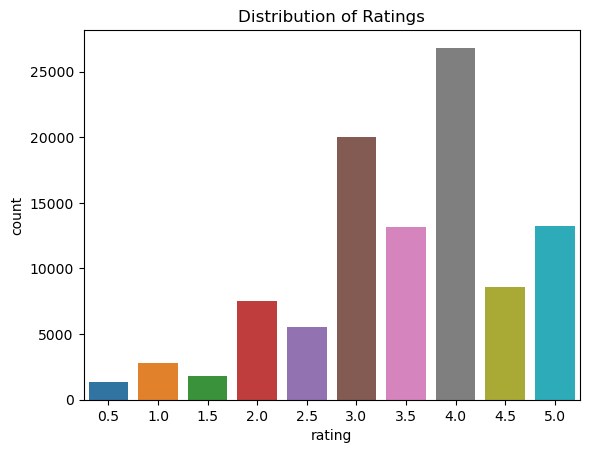

In [10]:
workingDir = r'dataset'

ratings = pd.read_csv(os.path.join(workingDir, r'ratings.csv'))
movies = pd.read_csv(os.path.join(workingDir, r'movies.csv'))

# Setup env for the surprise lib
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

sns.countplot(data=ratings, x='rating')
plt.title('Distribution of Ratings')
plt.show()

In [11]:
# Train SVD model
svd = SVD()
svd.fit(trainset)

# TF_IDF word corpus
corpus = movies['genres'].fillna('')


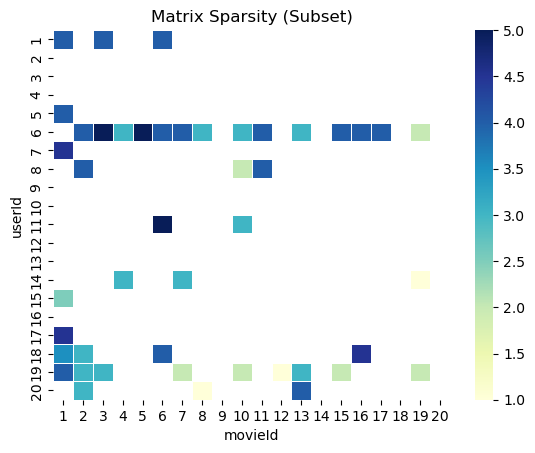

In [14]:
# 3. Matrix Sparsity
matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
# Visualize a subset of the matrix
subset_matrix = matrix.iloc[:20, :20]
sns.heatmap(subset_matrix, cmap="YlGnBu", linewidths=.5)
plt.title('Matrix Sparsity (Subset)')
plt.show()


In [15]:
# Ignore the words of the english (and, the, is etc.)
vectorizer = TfidfVectorizer(stop_words='english')

# Generate a sparse matrix of the genres
tfidf_matrix = vectorizer.fit_transform(corpus)
tfidf_matrix # 9742x23 === corpus

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)



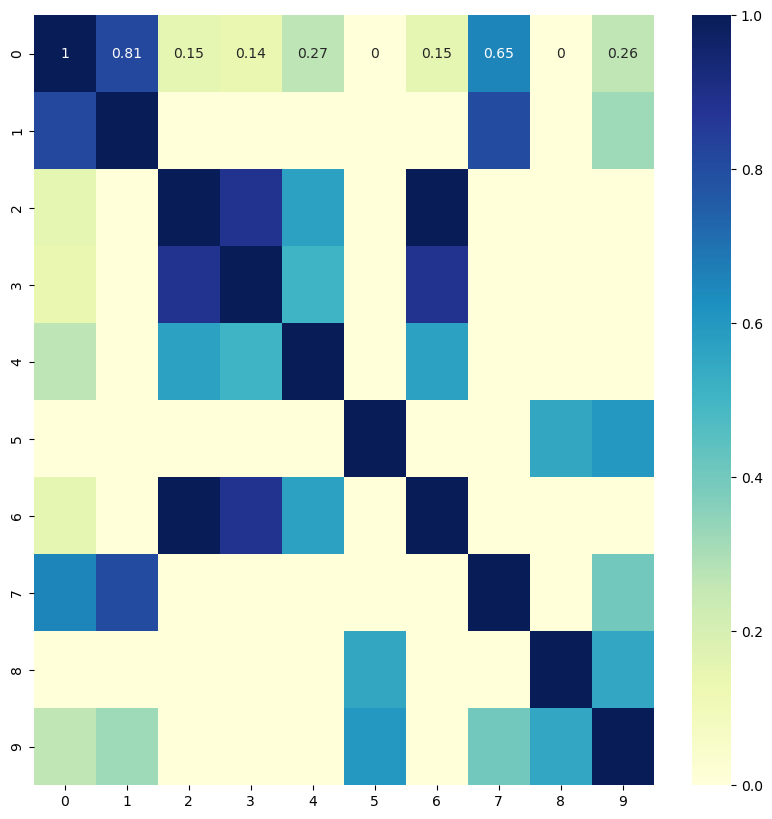

In [16]:


plt.figure(figsize=(10, 10))
sns.heatmap(cosine_sim[:10, :10], annot=True, cmap="YlGnBu")
plt.show()

In [17]:
def hybrid_recommendations(userId, num_recommendations=10):
    # Get the list of movieIds the user has rated
    user_ratings = ratings[ratings['userId'] == userId]
    
    # Predict ratings for all other movies
    predictions = []
    for movieId in movies['movieId']:
        if movieId not in user_ratings['movieId'].values:
            estimated_rating = svd.predict(userId, movieId).est
            predictions.append((movieId, estimated_rating))
            
    # Sort predictions by estimated rating
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    
    # Get top-N predictions
    top_n_predictions = predictions[:num_recommendations]
    
    # Retrieve most similar movies based on content
    recommendations = []
    for movieId, _ in top_n_predictions:
        movie_idx = movies.index[movies['movieId'] == movieId].tolist()[0]
        similar_movies = list(enumerate(cosine_sim[movie_idx]))
        similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:2]  # Get most similar movie
        for idx, _ in similar_movies:
            recommendations.append(movies.iloc[idx])
            
    return pd.DataFrame(recommendations)


In [18]:
userId = 1
print(hybrid_recommendations(userId))


      movieId                                          title  \
411       473                         In the Army Now (1994)   
10         11                 American President, The (1995)   
221       257                              Just Cause (1995)   
546       648                     Mission: Impossible (1996)   
24         25                       Leaving Las Vegas (1995)   
4125     5927    Best Little Whorehouse in Texas, The (1982)   
704       922  Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)   
6           7                                 Sabrina (1995)   
25         26                                 Othello (1995)   
4746     7070                               Red River (1948)   

                                 genres  
411                          Comedy|War  
10                 Comedy|Drama|Romance  
221                    Mystery|Thriller  
546   Action|Adventure|Mystery|Thriller  
24                        Drama|Romance  
4125       Comedy|Drama|Musical|Romance  
7

In [19]:
# Filter out ratings from userId 1
user_1_ratings = ratings[ratings['userId'] == 1]

# Merge with movies data to get genre information
merged = user_1_ratings.merge(movies, on='movieId', how='left')

# Explode the genres column (assuming genres are pipe-separated)
genres_exploded = merged['genres'].str.split('|', expand=True).stack()

# Count the frequency of each genre
genre_counts = genres_exploded.value_counts()

# Display top N genres. For example, top 5:
top_n_genres = genre_counts.head(5)
print(top_n_genres)


Action       90
Adventure    85
Comedy       83
Drama        68
Thriller     55
Name: count, dtype: int64
